<img src="mbit_logo.png" alt="drawing" align="right" style="float" width="150" height="150"/>

<font color="#D31525"><h3 align="left">Detección de fraude en transacciones financieras</h3></font>
<font color="#2C3E50"><h3 align="left"> UNDERSAMPLING, REDUCCIÓN DE DIMENSIONALIDAD Y GENERACIÓN DE DATASET DE ENTRENAMIENTO/TEST Y EVALUACIÓN </h3></font>

## Importar librerias
En esta primera parte del código, se realizan las llamadas a las librerías que se utilizarán en el Notebook:

In [1]:
# Paquetes de manipulación de datos
import pandas as pd
import numpy as np
import boto3

# Paquetes de visualización
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

# Paquetes de ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Matriz de correlacciones
Según el resultado de la matriz de correlacción aplicada en el Notebook `3b_discovery_nuevas_variables`:

In [2]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [3]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'df_new_var.csv',Filename = '/tmp/df_new_var.csv')

In [4]:
#Leemos el fichero y lo metemos en un dataframe.
df = pd.read_csv('/tmp/df_new_var.csv', dtype={'rank':'category'})

In [5]:
df.shape

(6362620, 19)

In [6]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/df_new_var.csv

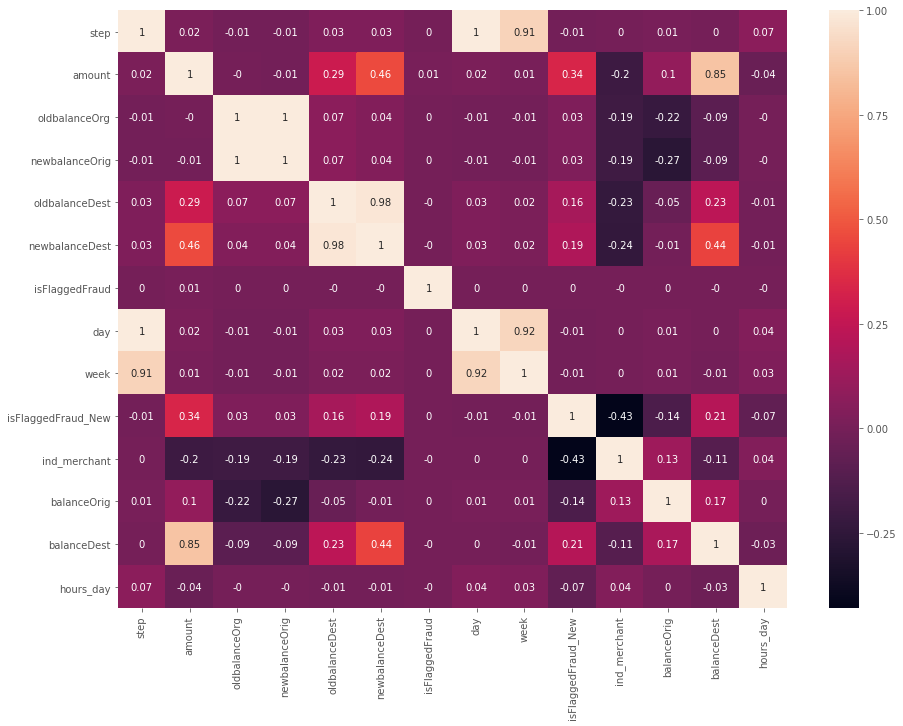

In [7]:
mydata_X = df.drop('isFraud', axis=1)

correlation_matrix = mydata_X.corr().round(2)
plt.subplots(figsize=(15,11))
cor = sns.heatmap(data=correlation_matrix, annot=True)

A la vista del gráfico, existe una fuerte dependencia entre las variables *newbalanceOrig* y *oldbalanceOrg* y entre *newbalanceDest* y *oldbalanceDest*. Estas relaciones de dependencia lineal entre las variables tienen sentido ya que suponen el aumento/disminución del balance se realiza sobre la misma cuenta móvil. Además, también existe una dependencia de 1 entre la variable *day* y *step* ya que ambas variables contienen la misma información en diferente escala y entre la variable *day* y *week* puesto que las dos recogen información de tiempo. Además, comprobamos que la variable *isFlaggedFraud* tiene poco poder predictivo puesto que es una variable que aporta muy poca información en el dataframe (total(1)'s: 16), por lo que el coeficiente de correlación de pearson no es capaz de encontrar relación entre esa variable y el resto de predictores.

Siguiendo el resultado de esta matriz de correlaciones, seleccionaríamos las variables: *newbalanceOrig*, *newbalanceDest*, *day*, *hours_day*, *isFlaggedFraud_New*, *balanceOrig*, *balanceDest* y también, la variable *type*.

Sin embargo, para ser más precisos, vamos a reducir el número de variables usando un modelo **random forest classifier**.

## Reducción de atributos

En primer lugar, eliminamos las variables de tipo indicador y aquellas que tienen una correlacción muy alta. Además, convertimos a dummies la variable *type*:

In [8]:
df6 = df.drop(['step', 'nameOrig', 'nameDest', 'amount_category', 'oldbalanceOrg', 'oldbalanceDest', 'week'], axis=1)
df6.shape

(6362620, 12)

In [9]:
df_Dummies = pd.get_dummies(df6)
df_Dummies.head()

,amount,newbalanceOrig,newbalanceDest,isFraud,isFlaggedFraud,day,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,160296.36,0.0,0.0,0.0,1,0,1,9839.64,0.0,1,0,0,0,1,0
1,1864.28,19384.72,0.0,0.0,0.0,1,0,1,1864.28,0.0,1,0,0,0,1,0
2,181.00,0.00,0.0,1.0,0.0,1,0,0,181.00,0.0,1,0,0,0,0,1
3,181.00,0.00,0.0,1.0,0.0,1,0,0,181.00,-21182.0,1,0,1,0,0,0
4,11668.14,29885.86,0.0,0.0,0.0,1,0,1,11668.14,0.0,1,0,0,0,1,0


Para iniciar con el modelo, separamos en X las variables independientes y en Y la variable dependiente.

In [10]:
y = df_Dummies.loc[:, 'isFraud'].values
X = df_Dummies.drop(columns=['isFraud']).values

Creamos los conjuntos de entrenamiento y test y aplicamos el modelo de Random Forest:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
# Entrenar el modelo de Random Forest:
forest = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

In [14]:
# Ordenar los atributos por importancia:
importances = forest.feature_importances_
imp_series = pd.Series(importances, index = df_Dummies.drop(columns=['isFraud']).dtypes.index).sort_values()[::-1]

In [15]:
# Imprimir la lista de los 20 atributos más informativos sobre la clase:
print(imp_series[:20])

balanceOrig           0.378488
balanceDest           0.167273
newbalanceDest        0.151210
amount                0.089406
day                   0.074372
hours_day             0.051844
type_TRANSFER         0.037794
type_CASH_OUT         0.021166
newbalanceOrig        0.020541
isFlaggedFraud_New    0.004017
type_PAYMENT          0.001471
isFlaggedFraud        0.000817
type_CASH_IN          0.000591
ind_merchant          0.000564
type_DEBIT            0.000447
dtype: float64


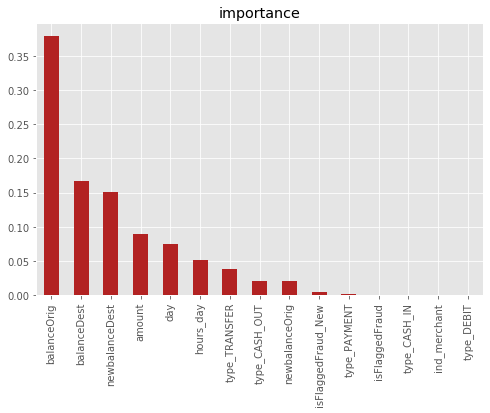

In [16]:
# Gráfica con los 20 atributos más importantes:
h = imp_series[:20].plot(kind = 'bar', figsize = (8, 5), title = "importance", color='firebrick')

Seleccionamos las variables *balanceOrig*, *balanceDest*, *newbalanceDest*, *amount*, *day*, *hours_day*, *type* y *newbalanceOrig* como atributos para nuestro futuro modelo de clasificación.

## Importar DataSets
Importamos los dataset de Train-Test y Evaluación sobre los que se ha aplicado el submuestreo en `4a_Undersampling_PCA`:

### Train_test

In [3]:
s3 = boto3.client("s3")

# Seleccionamos el bucket con el que vamos a trabajar
BUCKET_NAME = 'tfmfraud'

In [4]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'train_test_under.csv',Filename = '/tmp/train_test_under.csv')

In [5]:
#Leemos el fichero y lo metemos en un dataframe.
trainTest = pd.read_csv('/tmp/train_test_under.csv', dtype={'rank':'category'})

In [6]:
trainTest.shape

(74130, 18)

In [7]:
trainTest.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,week,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day
0,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1.0,0.0,1,1,0,0,181.0,0.00,1
1,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1.0,0.0,1,1,0,0,181.0,-21182.00,1
2,1,CASH_OUT,2806.00,C2101527076,2806.0,0.0,C1007251739,26202.0,0.00,1.0,0.0,1,1,0,0,2806.0,-26202.00,1
3,1,CASH_OUT,20128.00,C1118430673,20128.0,0.0,C339924917,6268.0,12145.85,1.0,0.0,1,1,0,0,20128.0,5877.85,1
4,1,CASH_OUT,416001.33,C749981943,0.0,0.0,C667346055,102.0,9291619.62,1.0,0.0,1,1,1,0,0.0,9291517.62,1


In [8]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_under.csv

In [12]:
pd.crosstab(index=trainTest['type'], columns=trainTest['isFraud'],
            margins=True).apply(lambda r: r/len(trainTest) *100,
                                axis=1)

isFraud,0.0,1.0,All
type,,,
CASH_OUT,72.727641,4.995279,77.722919
TRANSFER,17.272359,5.004721,22.277081
All,90.000000,10.000000,100.000000


In [10]:
trainTest_dis = trainTest[['balanceOrig', 'balanceDest', 'newbalanceDest', 'amount', 'day', 'hours_day', 'type', 'newbalanceOrig', 'isFraud']]
trainTest_dis.shape

(74130, 9)

### Evaluacion

In [17]:
# Descargamos el fichero del bucket de s3 a la máquina EC2 para poder trabajar con él.
s3.download_file(Bucket = BUCKET_NAME, Key = 'evaluacion_under.csv',Filename = '/tmp/evaluacion_under.csv')

In [18]:
#Leemos el fichero y lo metemos en un dataframe.
evaluacion = pd.read_csv('/tmp/evaluacion_under.csv', dtype={'rank':'category'})

In [19]:
evaluacion.shape

(80000, 18)

In [20]:
evaluacion.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,day,week,isFlaggedFraud_New,ind_merchant,balanceOrig,balanceDest,hours_day
0,425,CASH_OUT,10000000.00,C1979558927,10000000.00,0.0,C678340768,1727027.89,11727027.89,1.0,0.0,18,3,1,0,10000000.00,10000000.00,17
1,522,TRANSFER,545780.70,C1184365797,545780.70,0.0,C1197863823,0.00,0.00,1.0,0.0,22,3,1,0,545780.70,0.00,18
2,734,CASH_OUT,2079746.13,C1063299871,2079746.13,0.0,C884992368,0.00,2079746.13,1.0,0.0,31,4,1,0,2079746.13,2079746.13,14
3,102,TRANSFER,46081.45,C1009233877,46081.45,0.0,C1072793235,0.00,0.00,1.0,0.0,5,1,0,0,46081.45,0.00,6
4,398,CASH_OUT,50722.16,C688111556,50722.16,0.0,C679530338,21829.49,72551.64,1.0,0.0,17,3,0,0,50722.16,50722.15,14


In [21]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/evaluacion_under.csv

In [22]:
evaluacion_dis = evaluacion[['balanceOrig', 'balanceDest', 'newbalanceDest', 'amount', 'day', 'hours_day', 'type', 'newbalanceOrig', 'isFraud']]
evaluacion_dis.shape

(80000, 9)

## Guardamos los dos dataset con las variables seleccionadas

Sobre estos dataframes, ya se ha aplicado la técnica de submuestreo para ajustar la distribución de la clase minoritaria, y equilibrar el conjunto de datos. En este caso, hemos eliminado las tipologías de operación que no contemplan casos fraudulentos.

Guardamos los dataset de Train-Test y Evaluación con las variables seleccionadas:

In [29]:
trainTest_dis.to_csv('/tmp/train_test_under_dis.csv', index = False)
evaluacion_dis.to_csv('/tmp/eval_under_dis.csv', index = False)

In [30]:
s3.upload_file(Bucket = BUCKET_NAME, Key = 'train_test_under_dis.csv', Filename = '/tmp/train_test_under_dis.csv')
s3.upload_file(Bucket = BUCKET_NAME, Key = 'eval_under_dis.csv', Filename = '/tmp/eval_under_dis.csv')

In [31]:
# Eliminar el fichero de la ruta tmp de la máquina EC2 para no ocupar espacio.
!rm /tmp/train_test_under_dis.csv
!rm /tmp/eval_under_dis.csv